### Notebook
- Creates Figure S4: Sex- and age-specific MHC presentation of common driver mutations

In [11]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu, ks_2samp

import matplotlib.pyplot as plt
from matplotlib import gridspec 
import seaborn as sns
sns.set_style('white')
%matplotlib inline

### 0. Global variables

In [3]:
MSS = 'MSS_only' # MSS_only, MSS_and_MSI

mss_patients = np.loadtxt('../data/mss_tcga_patients.txt', dtype=str)

### Load patients

In [4]:
# Remove sex-specific cancers for sex-specific analyses
print('Loading confident {} patients with removed sex-specific cancers '.format(MSS))
confident_patients_I_rm_sex_specific = pd.read_csv('../generated_data/confident_patient_I.age_sex_disease.{}.remove_sex_specific.tsv'.format(MSS), sep='\t', index_col=0)
confident_patients_II_rm_sex_specific = pd.read_csv('../generated_data/confident_patient_II.age_sex_disease.{}.remove_sex_specific.tsv'.format(MSS), sep='\t', index_col=0)

print('{} confident MHC-I, {} confident MHC-II'.format(len(set(confident_patients_I_rm_sex_specific.index)), 
                                                       len(set(confident_patients_II_rm_sex_specific.index))))
confident_patients_I_rm_sex_specific.head(2)

Loading confident MSS_only patients with removed sex-specific cancers 
2554 confident MHC-I, 2681 confident MHC-II


,scores,disease,age,sex
TCGA-85-8580,0.120879,LUSC,52.0,female
TCGA-IB-AAUM,1.249676,PAAD,76.0,male


In [5]:
# Keep sex-specific cancers for age-specific analyses
print('Loading confident {} patients with kept sex-specific cancers'.format(MSS))
confident_patients_I_kept_sex_specific = pd.read_csv('../generated_data/confident_patient_I.age_sex_disease.{}.kept_sex_specific.tsv'.format(MSS), sep='\t', index_col=0)
confident_patients_II_kept_sex_specific = pd.read_csv('../generated_data/confident_patient_II.age_sex_disease.{}.kept_sex_specific.tsv'.format(MSS), sep='\t', index_col=0)

# set age threshold
young_thresh = 52 # 30th percentile: 52, 40th: 57
old_thresh = 68   # 70th percentile: 68, 60th: 65

# categorize age
confident_patients_I_kept_sex_specific['age_categorical_3070'] = pd.cut(confident_patients_I_kept_sex_specific['age'], [0, young_thresh, old_thresh, confident_patients_I_kept_sex_specific['age'].max()], labels=['younger', 'middle', 'older'])
confident_patients_II_kept_sex_specific['age_categorical_3070'] = pd.cut(confident_patients_II_kept_sex_specific['age'], [0, young_thresh, old_thresh, confident_patients_II_kept_sex_specific['age'].max()], labels=['younger', 'middle', 'older'])

confident_patients_I_kept_sex_specific = confident_patients_I_kept_sex_specific[confident_patients_I_kept_sex_specific['age_categorical_3070']!='middle']
confident_patients_II_kept_sex_specific = confident_patients_II_kept_sex_specific[confident_patients_II_kept_sex_specific['age_categorical_3070']!='middle']

print('{} confident MHC-I, {} confident MHC-II'.format(len(set(confident_patients_I_kept_sex_specific.index)), 
                                                       len(set(confident_patients_II_kept_sex_specific.index))))
confident_patients_I_kept_sex_specific.head(2)

Loading confident MSS_only patients with kept sex-specific cancers
1881 confident MHC-I, 1834 confident MHC-II


,scores,disease,age,sex,age_categorical_3070
TCGA-85-8580,0.120879,LUSC,52.0,female,younger
TCGA-IB-AAUM,1.249676,PAAD,76.0,male,older


### 1. Load data

##### 1A. Load driver mutation affinity data

In [7]:
# sex analysis
affinity_I_sex_df = pd.read_csv('../data/driver_mut.class_i.affinities.tsv.gz', sep='\t', index_col=0)
affinity_I_sex_df = affinity_I_sex_df[affinity_I_sex_df.index.isin(confident_patients_I_rm_sex_specific.index)]

affinity_II_sex_df = pd.read_csv('../data/driver_mut.class_ii.affinities.tsv.gz', sep='\t', index_col=0)
affinity_II_sex_df = affinity_II_sex_df[affinity_II_sex_df.index.isin(confident_patients_II_rm_sex_specific.index)]

In [8]:
# age analysis
affinity_I_age_df = pd.read_csv('../data/driver_mut.class_i.affinities.tsv.gz', sep='\t', index_col=0)
affinity_I_age_df = affinity_I_age_df[affinity_I_age_df.index.isin(confident_patients_I_kept_sex_specific.index)]

affinity_II_age_df = pd.read_csv('../data/driver_mut.class_ii.affinities.tsv.gz', sep='\t', index_col=0)
affinity_II_age_df = affinity_II_age_df[affinity_II_age_df.index.isin(confident_patients_II_kept_sex_specific.index)]

In [7]:
# # save patients
# np.savetxt('/cellar/users/andreabc/Data/hla_sex/clean_data/mhcI.sex.patients.txt', list(set(affinity_I_sex_df.index.values)), delimiter='\n', fmt='%s')
# np.savetxt('/cellar/users/andreabc/Data/hla_sex/clean_data/mhcII.sex.patients.txt', list(set(affinity_II_sex_df.index.values)), delimiter='\n', fmt='%s')
# np.savetxt('/cellar/users/andreabc/Data/hla_sex/clean_data/mhcI.age.patients.txt', list(set(affinity_I_age_df.index.values)), delimiter='\n', fmt='%s')
# np.savetxt('/cellar/users/andreabc/Data/hla_sex/clean_data/mhcII.age.patients.txt', list(set(affinity_II_age_df.index.values)), delimiter='\n', fmt='%s')

### 2. Plot Figure S4 A-D

Saving to ../figures/S4.sex_age_PHBR.MSS_only.A-D.pdf


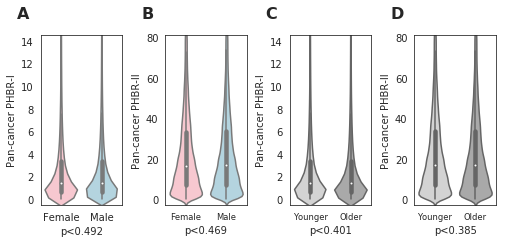

In [10]:
plt.figure(figsize=(7,3))

################################
# A. - All PHBR-I scores - Sex #
################################
plt.subplot(1,4,1)

data = affinity_I_sex_df.join(confident_patients_I_rm_sex_specific[['sex']]).reset_index()
data = pd.melt(data, id_vars=['sex', 'index']).drop_duplicates()

p = mannwhitneyu(data[data['sex']=='female'].index.values, data[data['sex']=='male'].index.values).pvalue
ax = sns.violinplot(x='sex', y='value', data=data, order=['female', 'male'], palette=['pink', 'lightblue'])

plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('Pan-cancer PHBR-I')
plt.xticks([0,1], ['Female', 'Male'])#, fontsize='small')
plt.ylim(ymin=-0.5, ymax=14.5)

plt.text(-0.3, 1.1, 'A', transform=ax.transAxes, fontsize=16, weight='bold')


#################################
# B. - All PHBR-II scores - Sex #
#################################
plt.subplot(1,4,2)

data = affinity_II_sex_df.join(confident_patients_II_rm_sex_specific[['sex']]).reset_index()
data = pd.melt(data, id_vars=['sex', 'index']).drop_duplicates()

p = mannwhitneyu(data[data['sex']=='female'].index.values, data[data['sex']=='male'].index.values).pvalue
ax = sns.violinplot(x='sex', y='value', data=data, order=['female', 'male'], palette=['pink', 'lightblue'])

plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('Pan-cancer PHBR-II')
plt.xticks([0,1], ['Female', 'Male'], fontsize='small')
plt.ylim(ymin=-2.7,ymax=81)

plt.text(-0.3, 1.1, 'B', transform=ax.transAxes, fontsize=16,  weight='bold')

################################
# C. - All PHBR-I scores - Age #
################################
plt.subplot(1,4,3)

data = affinity_I_age_df.join(confident_patients_I_kept_sex_specific[['age_categorical_3070']]).reset_index()
data = pd.melt(data, id_vars=['age_categorical_3070', 'index']).drop_duplicates()

p = mannwhitneyu(data[data['age_categorical_3070']=='younger'].index.values, data[data['age_categorical_3070']=='older'].index.values).pvalue
ax = sns.violinplot(x='age_categorical_3070', y='value', data=data, order=['younger', 'older'], palette=['lightgrey', 'darkgrey'])

plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('Pan-cancer PHBR-I')
plt.xticks([0,1], ['Younger', 'Older'], fontsize='small')
plt.ylim(ymin=-0.5, ymax=14.5)

plt.text(-0.3, 1.1, 'C', transform=ax.transAxes, fontsize=16,  weight='bold')

#################################
# D. - All PHBR-II scores - Age #
#################################
plt.subplot(1,4,4)

data = affinity_II_age_df.join(confident_patients_II_kept_sex_specific[['age_categorical_3070']]).reset_index()
data = pd.melt(data, id_vars=['age_categorical_3070', 'index']).drop_duplicates()

p = mannwhitneyu(data[data['age_categorical_3070']=='younger'].index.values, data[data['age_categorical_3070']=='older'].index.values).pvalue
ax = sns.violinplot(x='age_categorical_3070', y='value', data=data, order=['younger', 'older'], palette=['lightgrey', 'darkgrey'])

plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('Pan-cancer PHBR-II')
plt.xticks([0,1], ['Younger', 'Older'], fontsize='small')
plt.ylim(ymin=-2.7,ymax=81)

plt.text(-0.3, 1.1, 'D', transform=ax.transAxes, fontsize=16,  weight='bold')

# save figure
plt.tight_layout(pad=0.6, h_pad=1)

savepath = '../figures/S4.sex_age_PHBR.{}.A-D.pdf'.format(MSS)
print('Saving to {}'.format(savepath))
plt.savefig(savepath, bbox_inches="tight")
plt.show()

### 3. Plot Figure S4 E-F (ECDF)
- See median fraction of binding drivers along various 'binding' thresholds

In [12]:
# MHC-I 
thresholds_I = range(0,21,1)
f_medians_list_I, m_medians_list_I = [],[]
y_medians_list_I, o_medians_list_I = [],[]

for threshold in thresholds_I:
    # sex
    data = pd.DataFrame((affinity_I_sex_df < threshold).sum(axis=1) / len(affinity_I_sex_df.columns), 
                        columns=['fraction'])
    data = data.join(confident_patients_I_rm_sex_specific[['sex']])
    
    f_medians_list_I.append(data[data['sex']=='female'].fraction.median())
    m_medians_list_I.append(data[data['sex']=='male'].fraction.median())
    
    # age
    data = pd.DataFrame((affinity_I_age_df < threshold).sum(axis=1) / len(affinity_I_age_df.columns), 
                        columns=['fraction'])
    data = data.join(confident_patients_I_kept_sex_specific[['age_categorical_3070']])
    
    y_medians_list_I.append(data[data['age_categorical_3070']=='younger'].fraction.median())
    o_medians_list_I.append(data[data['age_categorical_3070']=='older'].fraction.median())

In [13]:
# MHC-II
thresholds_II = range(0,81,1)
f_medians_list_II, m_medians_list_II = [],[]
y_medians_list_II, o_medians_list_II = [],[]

for threshold in thresholds_II:
    # sex
    data = pd.DataFrame((affinity_II_sex_df < threshold).sum(axis=1) / len(affinity_II_sex_df.columns), 
                        columns=['fraction'])
    data = data.join(confident_patients_II_rm_sex_specific[['sex']])
    
    f_medians_list_II.append(data[data['sex']=='female'].fraction.median())
    m_medians_list_II.append(data[data['sex']=='male'].fraction.median())
    
    # age
    data = pd.DataFrame((affinity_II_age_df < threshold).sum(axis=1) / len(affinity_II_age_df.columns), 
                        columns=['fraction'])
    data = data.join(confident_patients_II_kept_sex_specific[['age_categorical_3070']])
    
    y_medians_list_II.append(data[data['age_categorical_3070']=='younger'].fraction.median())
    o_medians_list_II.append(data[data['age_categorical_3070']=='older'].fraction.median())

Saving to ../figures/S4_fraction_ECDF.E-F.pdf


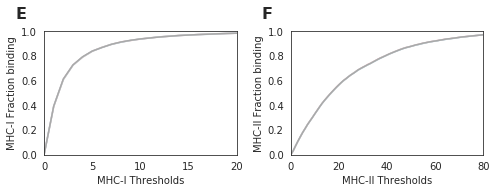

In [14]:
plt.figure(figsize=(7,2.5))

####################
# A. PHBR-I scores #
####################
fig = plt.subplot(1,2,1)

plt.plot(thresholds_I, f_medians_list_I, color='lightpink')  # Females
plt.plot(thresholds_I, m_medians_list_I, color='lightblue')  # Males
plt.plot(thresholds_I, y_medians_list_I, color='lightgrey')  # Younger
plt.plot(thresholds_I, o_medians_list_I, color='darkgrey')   # Older

plt.text(-0.15, 1.1, 'E', transform=fig.transAxes, fontsize=16,  weight='bold')
plt.xlabel('MHC-I Thresholds'), plt.ylabel('MHC-I Fraction binding')
plt.ylim(0,1), plt.xlim(0,20)

#####################
# B. PHBR-II scores #
#####################
fig = plt.subplot(1,2,2)

plt.plot(thresholds_II, f_medians_list_II, color='lightpink')  # Female
plt.plot(thresholds_II, m_medians_list_II, color='lightblue')  # Males
plt.plot(thresholds_II, y_medians_list_II, color='lightgrey')  # Younger
plt.plot(thresholds_II, o_medians_list_II, color='darkgrey')   # Older

plt.text(-0.15, 1.1, 'F', transform=fig.transAxes, fontsize=16,  weight='bold')
plt.xlabel('MHC-II Thresholds'), plt.ylabel('MHC-II Fraction binding')
plt.ylim(0,1), plt.xlim(0,80)

plt.tight_layout()
savepath = '../figures/S4_fraction_ECDF.E-F.pdf'
print('Saving to {}'.format(savepath)), plt.savefig(savepath, bbox_inches="tight")
plt.show()